The source code is in the public domain and not licensed or under
copyright. The information and software may be used freely by the public.
As required by 17 U.S.C. 403, third parties producing copyrighted works
consisting predominantly of the material produced by U.S. government
agencies must provide notice with such work(s) identifying the U.S.
Government material incorporated and stating that such material is not
subject to copyright protection.

Derived works shall not identify themselves in a manner that implies an
endorsement by or an affiliation with the Naval Research Laboratory.

RECIPIENT BEARS ALL RISK RELATING TO QUALITY AND PERFORMANCE OF THE
SOFTWARE AND ANY RELATED MATERIALS, AND AGREES TO INDEMNIFY THE NAVAL
RESEARCH LABORATORY FOR ALL THIRD-PARTY CLAIMS RESULTING FROM THE ACTIONS
OF RECIPIENT IN THE USE OF THE SOFTWARE.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
from scipy import constants as C
import scipy.interpolate
from cycler import cycler
# The following line provides interactive plots, and requires the ipympl package.
#%matplotlib widget

#lbl3 = [r'$x_1$ (mm)',r'$x_2$ (mm)',r'$x_3$ (mm)']
lbl3 = [r'$\varrho$ (mm)',r'$\varphi$',r'$z$ (mm)']
min_microns = 1.5
max_microns = 25
wavelength_res = 2 # quotient of wavelength to frequency points

mks_length = 0.8e-6/(2*np.pi)
#mks_length = 10.6e-6/(2*np.pi)
base_diagnostic = 'out/test'
uppe_list = glob.glob(base_diagnostic+'*_uppe_wave*.npy')
para_list = glob.glob(base_diagnostic+'*_paraxial_wave*.npy')
total_list = uppe_list + para_list
if 'uppe' in total_list[0]:
    real_field = True
else:
    real_field = False
nruns = len(total_list)

monochrome = (cycler('linewidth', [1.0,1.0,2.0,1.0,1.0]) + cycler('linestyle', ['-', '--','-',':', '-.']) )
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 12
plt.rcParams['axes.prop_cycle'] = monochrome

def get_freq_time_data(A,ext):
    if real_field:
        # Nodes are like [0,1,2,3] and walls are like [-0.5,0.5,1.5,2.5,3.5]
        # In these examples the user's requested upper bound would be 4 (it is thrown out)
        # Therefore element N/2+1 should be regarded as the central frequency
        dw = (ext[1] - ext[0])/A.shape[0]
        wc = 0.5*ext[0] + 0.5*(ext[1] + dw)
        tmax = 2*np.pi/dw
        w_nodes = np.linspace(ext[0]+dw/2,ext[1]-dw/2,A.shape[0])
        return dw,wc,tmax,w_nodes
    else:
        # Nodes are like [-2,-1,0,1] and walls are like [-2.5,-1.5,-.5,.5,1.5]
        dw = (ext[1] - ext[0])/A.shape[0]
        wc = 0.5*ext[0] + 0.5*(ext[1] + dw)
        tmax = 2*np.pi/dw
        w_nodes = np.linspace(ext[0]+dw/2,ext[1]-dw/2,A.shape[0])
        return dw,wc,tmax,w_nodes

def get_spectral_power(A,wn,z,rmin=0.0):
    # Specializing for cylindrical right now
    # Units will not be correct without applying scale factor externally (see below)
    Ew2 = (np.abs(A[...,z]*wn[...,np.newaxis,np.newaxis])**2)[::-1]
    El2 = np.zeros((Ew2.shape[0]*wavelength_res,)+Ew2.shape[1:])
    l_array_nu = (mks_length*2*np.pi/wn)[::-1]
    l_array = np.linspace(l_array_nu[0],1e-6*max_microns,El2.shape[0])
    for i in range(El2.shape[1]):
        for j in range(El2.shape[2]):
                fi = scipy.interpolate.interp1d(l_array_nu,Ew2[:,i,j])
                El2[:,i,j] = fi(l_array)/l_array**2
    dr = (data_ext[3]-data_ext[2])/El2.shape[1]
    r = np.linspace(data_ext[2]+0.5*dr,data_ext[3]-0.5*dr,El2.shape[1])
    dS = (np.pi*(r+0.5*dr)**2 - np.pi*(r-0.5*dr)**2)
    r_idx = np.searchsorted(r,rmin)
    return l_array,np.sum(El2[:,r_idx:,0]*dS[np.newaxis,r_idx:],axis=1)

def get_power(A,wn,z):
    # Specializing for cylindrical right now
    E2 = np.fft.irfft(1j*wn[...,np.newaxis,np.newaxis]*A[...,z],axis=0)**2
    E2 *= (C.m_e*C.c**2/mks_length/C.e)**2
    intensity_mks = E2/377
    dr = (data_ext[3]-data_ext[2])/E2.shape[1]
    r = np.linspace(data_ext[2]+0.5*dr,data_ext[3]-0.5*dr,E2.shape[1])
    dS_mks = mks_length**2*(np.pi*(r+0.5*dr)**2 - np.pi*(r-0.5*dr)**2)
    return np.sum(intensity_mks*dS_mks[np.newaxis,:,np.newaxis],axis=(1,2))

z00 = []
dz = []
U00 = []
ln = []
power = []

for file in sorted(total_list):
    A = np.load(file)
    s = file.split('_')
    data_ext_name = s[0]
    for word in s[1:-1]:
        data_ext_name += '_' + word
    data_ext_name += '_plot_ext.npy'
    data_ext = np.load(data_ext_name)
    dw,wc,tmax,wn = get_freq_time_data(A,data_ext)
    wn += 1e-9
    Nz = A.shape[3]
    dz.append(mks_length*(data_ext[7]-data_ext[6])/(Nz-1))
    z00.append(mks_length*data_ext[6])
    # Calibration of spectral power using initial condition
    P0 = get_power(A,wn,0)
    U00.append(np.sum(P0)*tmax*mks_length/C.c/P0.shape[0])
    res = get_spectral_power(A,wn,0)
    ln.append(res[0])
    U00w = np.sum(res[1])*(ln[-1][1]-ln[-1][0])
    # Get spectral power at all z positions
    Pz = np.zeros((Nz,res[1].shape[0]))
    for k in range(Nz):
        res = get_spectral_power(A,wn,k)
        Pz[k,:] = res[1] * U00[-1]/U00w # put in J per meter of wavelength
    power.append(np.copy(Pz))

plt.close('all')

In [2]:
print('Pulse energy =',U00)
print(sorted(total_list))

Pulse energy = [0.006295428630997379, 0.006295428630997379, 0.006295428630997379, 0.006295428630997379, 0.006295428630997379]
['out/test_0_air_uppe_wave.npy', 'out/test_1_air_uppe_wave.npy', 'out/test_2_air_uppe_wave.npy', 'out/test_3_air_uppe_wave.npy', 'out/test_4_air_uppe_wave.npy']


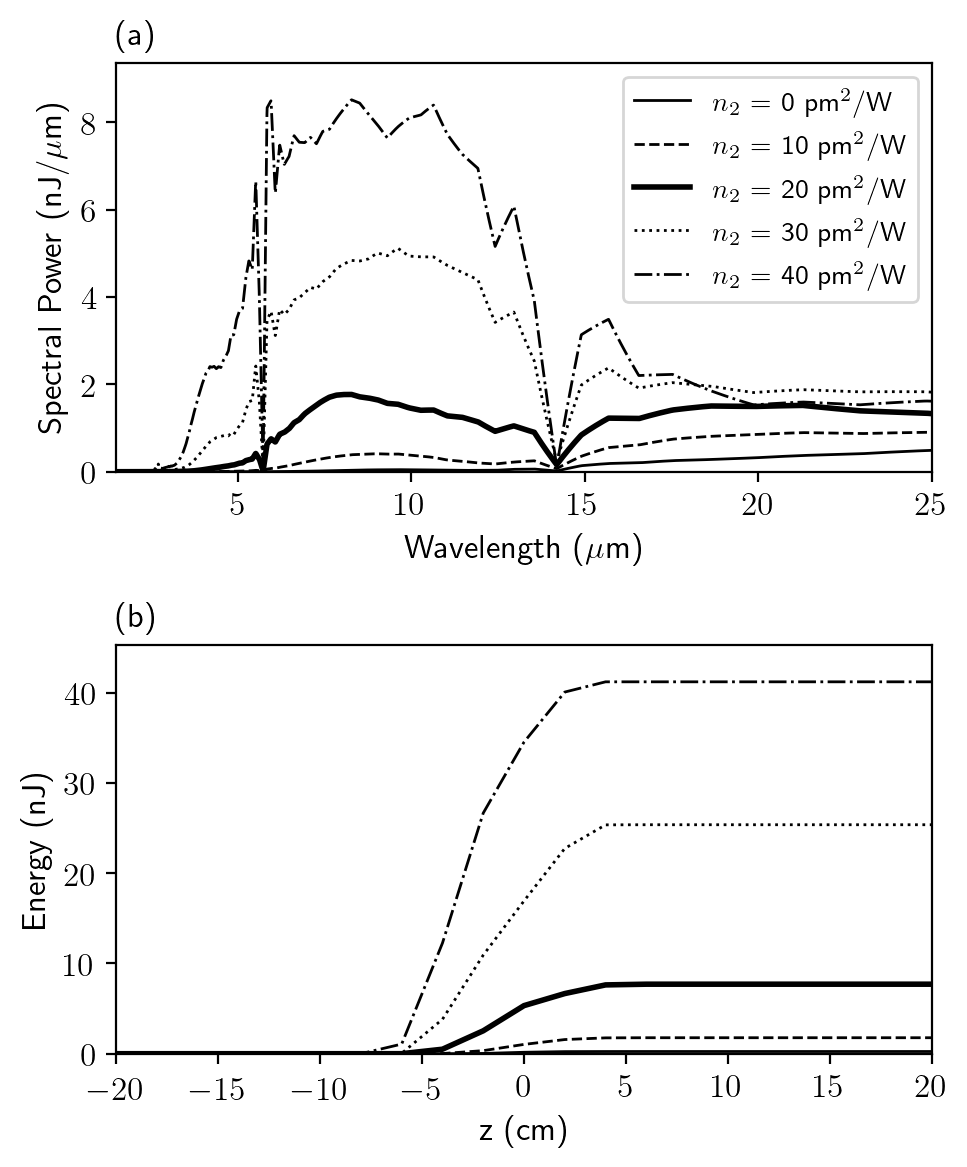

In [3]:
max_pwr = 0.0
for irun in range(nruns):
    l_idx = np.searchsorted(ln[irun],1e-6*min_microns)
    max_pwr = np.max([max_pwr,np.max(power[irun][-1,l_idx:])])

integration_range_um = (8,14)
LWIR_energy = []
for irun in range(nruns):
    low_idx = np.searchsorted(ln[irun],integration_range_um[0]*1e-6)
    high_idx = np.searchsorted(ln[irun],integration_range_um[1]*1e-6)
    Nz = power[irun].shape[0]
    Uz = np.zeros(Nz)
    for k in range(Nz):
        Uz[k] = np.sum(power[irun][k,low_idx:high_idx])*(ln[irun][1]-ln[irun][0])
    LWIR_energy.append(Uz)

plt.figure(figsize=(5,6),dpi=200)
plt.subplot(211)
for irun in range(0,nruns):
    n2 = '{:.0f}'.format(10*irun)
    plt.plot(ln[irun]*1e6,power[irun][-1,:]*1e3,label='$n_2$ = '+n2+r' pm$^2/$W')
plt.xlim(min_microns,max_microns)
plt.ylim(0,1.1*max_pwr*1e3)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Spectral Power (nJ/$\mu$m)')
plt.legend(fontsize=10)
plt.text(min_microns,1.15*max_pwr*1e3,'(a)')
plt.subplot(212)
max_energy = 0.0
for irun in range(0,nruns):
    Nz = power[irun].shape[0]
    z = np.linspace(z00[irun],z00[irun]+dz[irun]*(Nz-1),Nz)
    plt.plot(z*100,LWIR_energy[irun]*1e9)
    max_energy = np.max([max_energy,np.max(LWIR_energy[irun])])
plt.xlabel('z (cm)')
plt.ylabel('Energy (nJ)')
plt.xlim(z[0]*100,z[-1]*100)
plt.ylim(0,1.1*max_energy*1e9)
plt.text(z[0]*100,1.15*max_energy*1e9,'(b)')
plt.tight_layout()